# GTHA housing market database
# OSEMN methodology Step 4: Model
# Two features
---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, fit_norm_dist

## Load Teranet data

In [3]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 121.14 seconds
with 5,188,513 rows
and 80 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [5]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [6]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.25 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Join Census data to Teranet data

In [7]:
t = time()
df = pd.merge(df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 58.09 seconds (0.97 minutes)
with 5,188,513 rows
and 110 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=110)


## Take a train-test and two validation subsets from Teranet records
Subset of Teranet records from 2011 is used to train and test a machine learning algorithm classifying the three reduced categories of land use ("house", "condo" or "other"), as derived in this notebook from the detailed land use provided by the Department of Geography.

Subsets of Teranet records from 2010 and 2012 are used to validate algorithm's predictions.

In [8]:
year_train_test = 2011
year_val1 = 2010
year_val2 = 2012

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

219,130 Teranet records in the train-test subset (records from 2011).
216,492 Teranet records in the validation subset #1 (records from 2010).
205,341 Teranet records in the validation subset #2 (records from 2012).


## Select features

In [9]:
feat_1 = 'Avg_HHsize'
feat_2 = 'xy_total_sales'

s = s.dropna(subset=[feat_1, feat_2])
s_val1 = s_val1.dropna(subset=[feat_1, feat_2])
s_val2 = s_val2.dropna(subset=[feat_1, feat_2])
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

217,955 rows in train-test subset, 216,155 rows in validation subset #1, 204,722 rows in validation subset #2


## Exploratory Data Analysis (EDA)

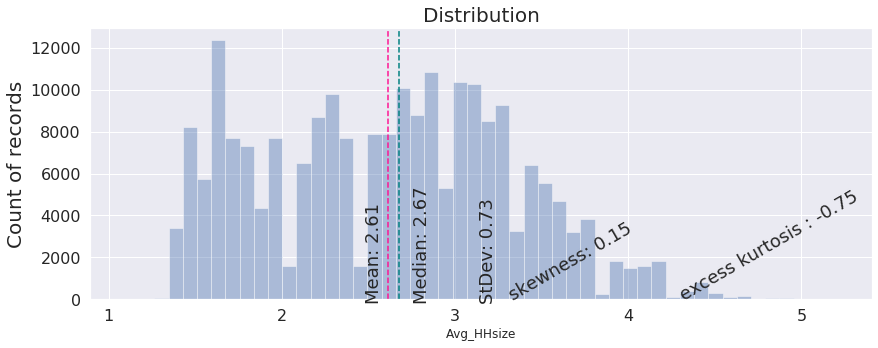

In [10]:
plot_hist(s[feat_1], med_xlift=1.03, mean_xlift=0.95, sdev_xlift=1.2, skew_xlift=1.05)

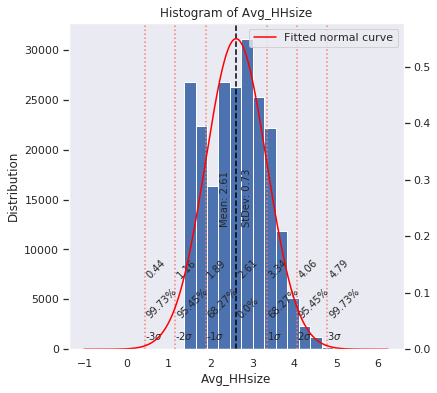


----- Shapiro-Wilks normality test results:
W = 0.973, p-value = 0.000
Sample does not look Gaussian (reject H0)

----- D’Agostino’s K^2 normality test results:
s^2 + k^2 = 15676.218, p-value = 0.000,
where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest
and p-value is a 2-sided chi squared probability for the hypothesis test.
Sample does not look Gaussian (reject H0)

----- Anderson-Darling Test results:
Statistic: 1505.261
Sigificance level: critical value
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


count    217955.000000
mean          2.613434
std           0.725773
min           1.100000
25%           2.000000
50%           2.675000
75%           3.137500
max           5.200000
Name: Avg_HHsize, dtype: float64

In [11]:
fit_norm_dist(s[feat_1], h_bins=15, lab2='from_mean', mean_lift=0.85, std_lift=1.05)

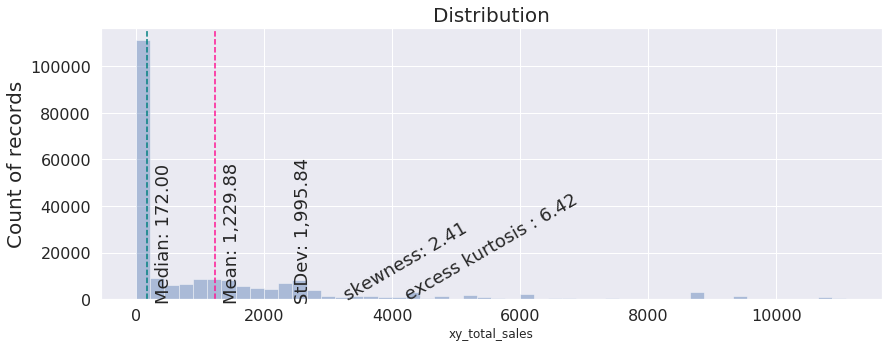

In [12]:
plot_hist(s[feat_2], med_xlift=1.7, mean_xlift=1.1, sdev_xlift=2, skew_xlift=1.3)

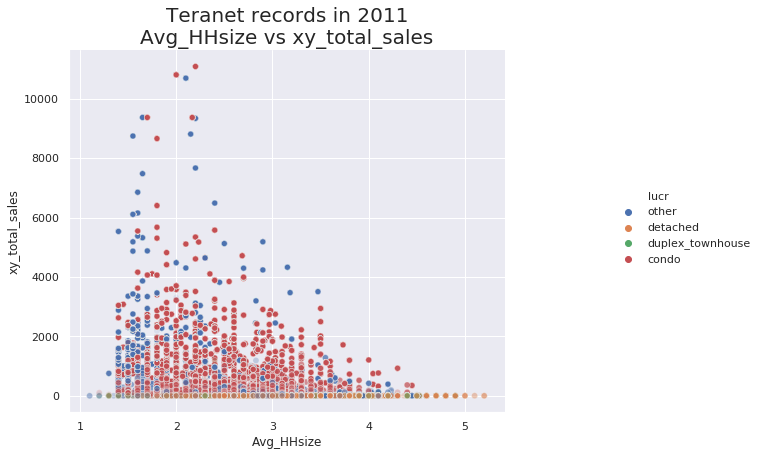

In [13]:
g = sns.relplot(data=s, x=feat_1, y=feat_2, hue='lucr', alpha=0.1)
g.fig.set_size_inches(12, 6)
ax = plt.gca()
ax.set_title("Teranet records in {0}\n{1} vs {2}".format(year_train_test, feat_1, feat_2), fontsize=20)
plt.show()

## Prepare features and target

### Encode target

In [14]:
le = LabelEncoder()
s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop('lucr', axis=1)
s_val1 = s_val1.drop('lucr', axis=1)
s_val2 = s_val2.drop('lucr', axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               62648
detached            60414
duplex_townhouse    13709
other               81184
Name: lucr, dtype: int64
0    62648
1    60414
2    13709
3    81184
Name: lucr_e, dtype: int64
condo               66944
detached            63074
duplex_townhouse    14423
other               71714
Name: lucr, dtype: int64
0    66944
1    63074
2    14423
3    71714
Name: lucr_e, dtype: int64
condo               55527
detached            59684
duplex_townhouse    13251
other               76260
Name: lucr, dtype: int64
0    55527
1    59684
2    13251
3    76260
Name: lucr_e, dtype: int64
Land use encoded!


### Select features and target

In [15]:
X = s[[feat_1, feat_2]].values
X_val1 = s_val1[[feat_1, feat_2]].values
X_val2 = s_val2[[feat_1, feat_2]].values

y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


### Perform train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [62648 60414 13709 81184]
Labels counts in y_train: [43853 42290  9596 56829]
Labels counts in y_test: [18795 18124  4113 24355]
Labels counts in y_val1: [66944 63074 14423 71714]
Labels counts in y_val2: [55527 59684 13251 76260]


### Standardize features

In [17]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


### Normalize features

In [18]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


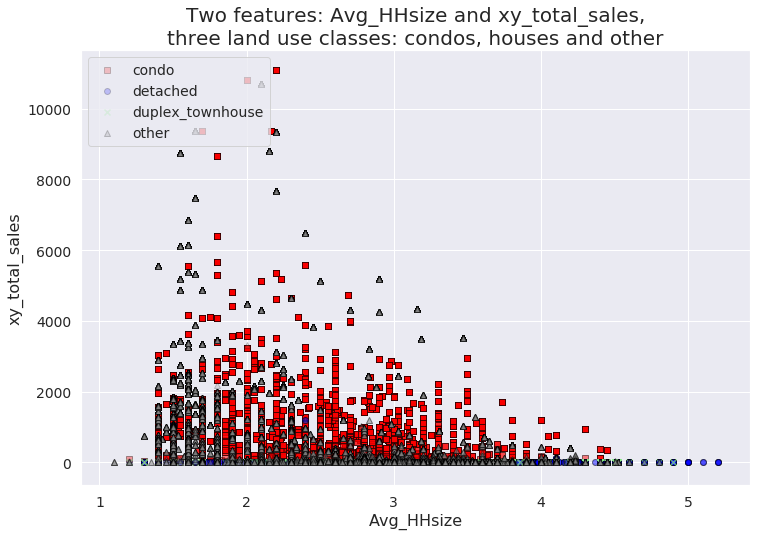

In [19]:
markers = ('s', 'o', 'x', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y))])
plt.figure(figsize=(12, 8))
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                c=colors[idx], marker=markers[idx], label=cl, edgecolor='black', alpha=0.2)
plt.xlabel(feat_1, fontsize=16)
plt.ylabel(feat_2, fontsize=16)
plt.title("Two features: {0} and {1},\nthree land use classes: condos, houses and other"
          .format(feat_1, feat_2),
          fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
plt.show()

## Train and test classification algorithms

### Perceptron learning algorithm


Perceptron (raw features) fit, took 0.56 seconds (0.01 minutes)
accuracy: train=0.40, test=0.41, validation #1=0.38, validation #2=0.39

Perceptron (standardized features) fit, took 0.34 seconds (0.01 minutes)
accuracy: train=0.46, test=0.46, validation #1=0.44, validation #2=0.45

Perceptron (normalized features) fit, took 0.49 seconds (0.01 minutes)
accuracy: train=0.49, test=0.50, validation #1=0.47, validation #2=0.52


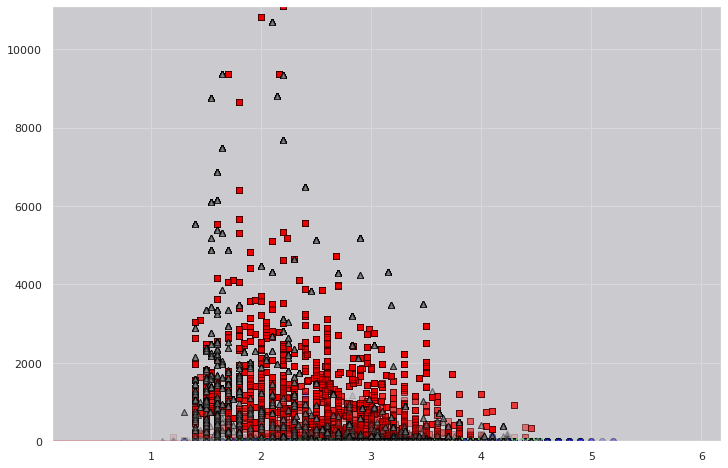

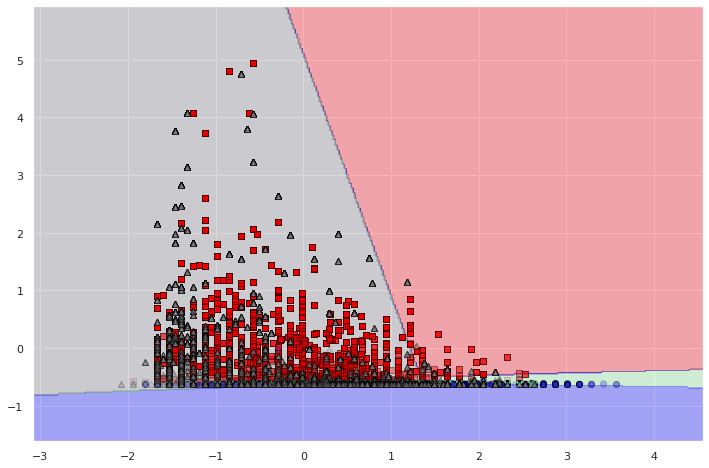

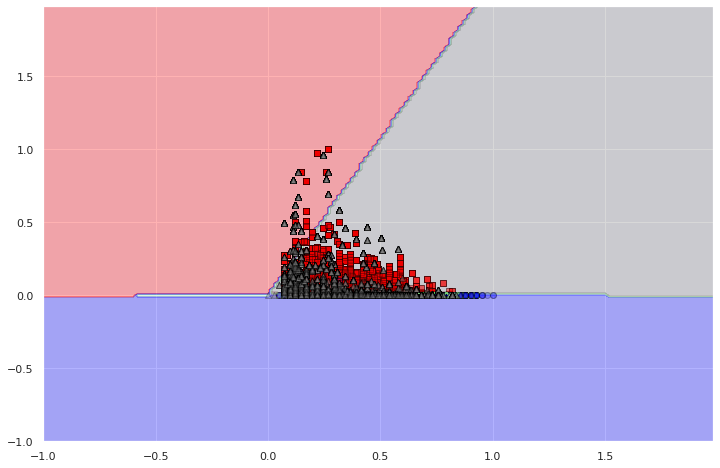

In [20]:
model_name = 'Perceptron (raw features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2, 
          plot_dec_reg='train-test')

model_name = 'Perceptron (standardized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2, 
          plot_dec_reg='train-test')

model_name = 'Perceptron (normalized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2, 
          plot_dec_reg='train-test')

### Logistic regression

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (raw features) fit, took 5.83 seconds (0.10 minutes)
accuracy: train=0.51, test=0.51, validation #1=0.46, validation #2=0.51

Logistic regression (standardized features) fit, took 2.67 seconds (0.04 minutes)
accuracy: train=0.50, test=0.50, validation #1=0.46, validation #2=0.50


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (normalized features) fit, took 4.27 seconds (0.07 minutes)
accuracy: train=0.50, test=0.50, validation #1=0.47, validation #2=0.50


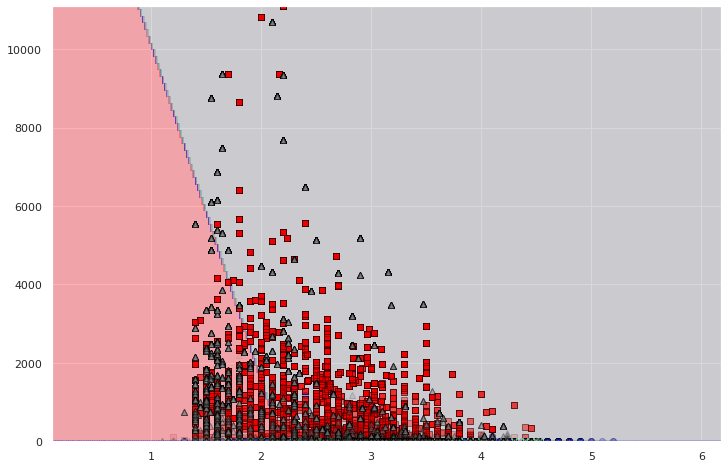

In [21]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto')
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2, 
          plot_dec_reg='train-test')

model_name = 'Logistic regression (standardized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto')
fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Logistic regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto')
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)

### Decision Tree


Decision Tree (raw features) fit, took 0.14 seconds (0.00 minutes)
accuracy: train=0.67, test=0.67, validation #1=0.69, validation #2=0.64


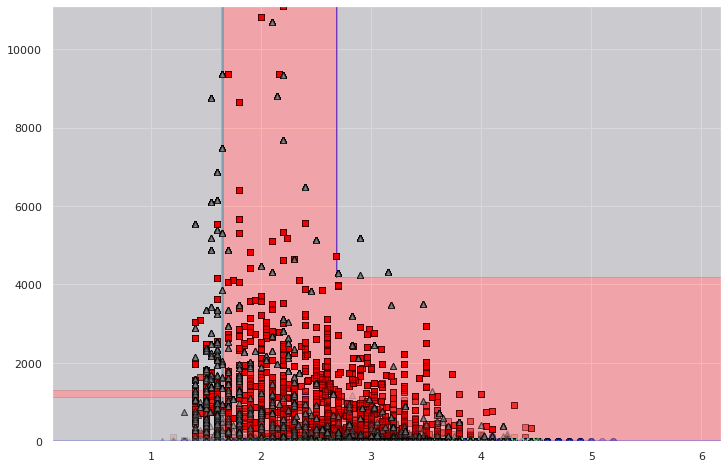

In [22]:
model_name = 'Decision Tree (raw features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2, 
          plot_dec_reg='train-test')

### Random Forest

In [ ]:
model_name = 'Random Forest (raw features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2, 
          plot_dec_reg='train-test')


Random Forest (raw features) fit, took 2.07 seconds (0.03 minutes)
accuracy: train=0.86, test=0.85, validation #1=0.84, validation #2=0.74


### K-nearest neighbors

In [ ]:
model_name = 'K-nearest neighbors (raw features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2, 
          plot_dec_reg='train-test')

model_name = 'K-nearest neighbors (standardized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'K-nearest neighbors (normalized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)